In [1]:
import pandas as pd
import numpy as np
import os
import sys
import numbers
def apply_filter_query(df, filters=None):
	"""
	Use the DataFrame.query method to filter a table down to the
	desired rows.

	Parameters
	----------
	df : pandas.DataFrame
	filters : list of str or str, optional
		List of filters to apply. Will be joined together with
		' and ' and passed to DataFrame.query. A string will be passed
		straight to DataFrame.query.
		If not supplied no filtering will be done.

	Returns
	-------
	filtered_df : pandas.DataFrame

	"""
	if filters:
		if isinstance(filters, str):
			query = filters
		else:
			query = ' and '.join(filters)
		return df.query(query)
	else:
		return df
def _filterize(name, value):
	"""
	Turn a `name` and `value` into a string expression compatible
	the ``DataFrame.query`` method.

	Parameters
	----------
	name : str
		Should be the name of a column in the table to which the
		filter will be applied.

		A suffix of '_max' will result in a "less than" filter,
		a suffix of '_min' will result in a "greater than or equal to" filter,
		and no recognized suffix will result in an "equal to" filter.
	value : any
		Value side of filter for comparison to column values.

	Returns
	-------
	filter_exp : str

	"""
	if name.endswith('_min'):
		name = name[:-4]
		comp = '>='
	elif name.endswith('_max'):
		name = name[:-4]
		comp = '<'
	else:
		comp = '=='

	result = '{} {} {!r}'.format(name, comp, value)
	return result

def filter_table(table, filter_series, ignore=None):
	"""
	Filter a table based on a set of restrictions given in
	Series of column name / filter parameter pairs. The column
	names can have suffixes `_min` and `_max` to indicate
	"less than" and "greater than" constraints.

	Parameters
	----------
	table : pandas.DataFrame
		Table to filter.
	filter_series : pandas.Series
		Series of column name / value pairs of filter constraints.
		Columns that ends with '_max' will be used to create
		a "less than" filters, columns that end with '_min' will be
		used to create "greater than or equal to" filters.
		A column with no suffix will be used to make an 'equal to' filter.
	ignore : sequence of str, optional
		List of column names that should not be used for filtering.

	Returns
	-------
	filtered : pandas.DataFrame

	"""
	ignore = ignore if ignore else set()

	filters = [_filterize(name, val)
				for name, val in filter_series.iteritems()
				if not (name in ignore or
						(isinstance(val, numbers.Number) and
						np.isnan(val)))]

	return apply_filter_query(table, filters)
run_folder = "/home/da/semcog_urbansim/runs"
run_num = "run1135"
hdf = pd.HDFStore(os.path.join(run_folder, '%s.h5'%run_num), 'r')

### GQ

In [9]:
gqct = hdf['/base/group_quarters_control_totals']

In [40]:
gqct.loc[:, 'sim'] = 0
for year in range(2020, 2051):
	p = hdf['/%s/parcels' % year]
	b = hdf['/%s/buildings' % year]
	gq = hdf['/%s/group_quarters' % year]
	b = b.join(p.city_id, on='parcel_id')
	gq = gq.join(b.city_id, on='building_id')
	gqct.loc[gqct.year==year, 'sim'] = gq.city_id.value_counts()


In [74]:
(gqct.sim.fillna(0) - gqct['count']).abs().sort_values(ascending=False).iloc[40:]

cityid
4005    855.0
4005    851.0
4005    849.0
2285    149.0
2285    129.0
        ...  
6075      0.0
6060      0.0
6045      0.0
6040      0.0
7100      0.0
Length: 6873, dtype: float64

In [ ]:
gqct.loc[4005]

In [31]:
gq_buildings = pd.read_excel(r'~/share/urbansim/RDF2050/model_inputs/base_tables/group_quarters/GQ_ControlTotals.xlsx',
                             sheet_name="BuildingLevel")

In [39]:
base_b = hdf['/base/buildings']
gq_buildings[~gq_buildings.building_id.isin(base_b.index.unique())]
#.to_csv("~/share/da/Staff/Xie/share/model/missing_gq_buildings.csv")

,city_id,primary_PUMA,secondary_PUMA,building_id,resident_count,GQ_code,RELSHIPP,age_grp
1003,1015,3206,3205,1462168,9,801,38,65+
1351,2115,2902,3001,2372929,2,801,38,65+
1793,3130,3006,3003,3331889,2,801,38,65+
2221,541,3208; 3209; 3210; 3211; 3112,NaN,8257421,2,801,38,65+


### HH

#### Matching mcd total

In [4]:
hh = hdf['/2050/households']
b = hdf['/2050/buildings']
hh = hh.join(b[['city_id']], on='building_id')
hh.city_id.value_counts()

3130.0    56604
3115.0    56188
4005.0    54628
3030.0    47418
1120.0    40006
          ...  
2172.0       59
3045.0       37
551.0        34
2252.0        8
2073.0        8
Name: city_id, Length: 289, dtype: int64

In [5]:
citytotal = pd.read_csv('/home/da/share/urbansim/RDF2050/model_inputs/base_tables/mcd_totals_2020_2050.csv', index_col='mcd')

In [18]:
dif = (hh.city_id.value_counts() - citytotal['2050'])
dif = dif[dif.notna()]
dif.sort_values().to_csv('test.csv')

#### HH by mcd

In [8]:
year = 2020
# db = hdf['/%s/dropped_buildings' % year]
b = hdf['/%s/buildings' % year]
hh = hdf["/%s/households" % year]
p = hdf['/%s/parcels' % year]
# db = db.join(p.city_id, on='parcel_id')
b = b.join(p.city_id, on='parcel_id')
hh = hh.join(b.city_id, on='building_id')

In [10]:
hh.city_id.fillna(-1).astype(int).value_counts()

3130    54629
3115    51436
4005    49854
3030    44527
1120    39227
        ...  
2172       58
3045       36
2252        8
2073        5
6142        1
Name: city_id, Length: 291, dtype: int64

In [14]:
hh_by_mcd_year = pd.DataFrame(index=p.city_id.unique()).sort_index()
hh_by_mcd_year

""
501
502
503
504
505
...
7080
7085
7090
7095


In [15]:
hu_vcount = b[['city_id', 'residential_units']].groupby('city_id').sum()['residential_units']
hu_vcount

city_id
501      3168.0
502      7502.0
503      3251.0
504      5544.0
505     11363.0
         ...   
7080     5548.0
7085      907.0
7090     2502.0
7095     4509.0
7100     1502.0
Name: residential_units, Length: 291, dtype: float64

#### Zonal dist

In [56]:
def make_hh_la(households, buildings):
    h = pd.merge(households, buildings[['city_id', 'zone_id']],
                 left_on='building_id', right_index=True, how='left')
    #h = h.loc[h.large_area_id == large_area_id]

    # if zone_id == -1, replace them with 0
    h['zone_id'] = h['zone_id'].clip(0)

    h['city_zone'] = h.city_id * 10000 + h.zone_id
    h['hhsize'] = h.persons
    h.loc[h.persons > 7, 'hhsize'] = 7
    h['inc_qt'] = pd.qcut(h.income, 4, labels=[1, 2, 3, 4])
    return h
def cal_weights(hbase):
    hbase['concat'] = hbase.inc_qt.astype(int).map(str) + '-' + hbase.hhsize.map(str)
    hbase['concat'] = hbase['concat'] + '-' + hbase.large_area_id.astype(int).map(str)
    hbase['concat'] = hbase['concat'] + '-' + hbase.city_id.astype(int).map(str)
    hbase['concat'] = hbase['concat'] + '-' + hbase.city_zone.astype(int).map(str)

    hbase_zone = hbase.groupby('concat').size()
    hbase_zone.name = 'weights'
    hbase_zone = hbase_zone * 1.00
    hbase_zone += 0.001

    # restore all columns from concat string
    hbase_zone = hbase_zone.reset_index()
    hbase_zone['inc_qt'] = hbase_zone['concat'].str.split('-').str[0].astype(int)
    hbase_zone['hhsize'] = hbase_zone['concat'].str.split('-').str[1].astype(int)
    hbase_zone['large_area_id'] = hbase_zone['concat'].str.split('-').str[2].astype(int)
    hbase_zone['city_id'] = hbase_zone['concat'].str.split('-').str[3].astype(int)
    hbase_zone['city_zone'] = hbase_zone['concat'].str.split('-').str[4].astype(int)
    hbase_zone = hbase_zone.drop(columns='concat')

    return hbase_zone.set_index(['large_area_id', 'inc_qt', 'hhsize', 'city_id', 'city_zone'])


In [40]:
base_hh = hdf['/base/households']
p = hdf['/base/parcels']
b = hdf['/base/buildings'].join(p[['zone_id']], on='parcel_id')
hbase = make_hh_la(base_hh, b)
hbase_zone_base = cal_weights(hbase)

In [57]:
zd_hh = hdf['/2024/households']
p = hdf['/2024/parcels']
b = hdf['/2024/buildings'].join(p[['zone_id']], on='parcel_id')
hbase = make_hh_la(zd_hh, b)
hbase_zone_22 = cal_weights(hbase)

In [51]:
orig_hh = hdf['/2024/households_before_zd']
orig_hh = orig_hh[orig_hh.building_id>0]
p = hdf['/2024/parcels']
b = hdf['/2024/buildings'].join(p[['zone_id']], on='parcel_id')
hbase = make_hh_la(orig_hh, b)
hbase_zone_orig = cal_weights(hbase)

In [58]:
hbase_zone_22

weights
large_area_id inc_qt hhsize city_id city_zone         
115           1      1      5005    50052461    97.001
                                    50052462    62.001
                                    50052464    35.001
                                    50052465    51.001
                                    50052466     9.001
...                                                ...
99            4      7      3130    31301735     4.001
                            3135    31352017    10.001
                                    31352018     2.001
                                    31352021    16.001
                                    31352024     1.001

[53345 rows x 1 columns]

In [46]:
(hbase_zone_22 - hbase_zone_base).abs().sum()

weights    230284.0
dtype: float64

In [48]:
(hbase_zone_orig - hbase_zone_base).abs().sum()

weights    231412.0
dtype: float64

In [49]:
(231412.0 - 230284.0)/230284

0.004898299491063209

In [52]:
(hbase_zone_22 - hbase_zone_base).abs().sum()

weights    237553.0
dtype: float64

In [53]:
(hbase_zone_orig - hbase_zone_base).abs().sum()

weights    310712.0
dtype: float64

In [54]:
(310712.0 - 237553.0) / 237553

0.30796916898544746

##### ZD review charts

In [17]:
import matplotlib.pyplot as plt
def prepare_data(hdf, year):
    h = hdf[year + '/households']
    p = hdf[year + '/parcels']
    b = hdf[year + '/buildings']
    b = b.join(p[['zone_id']], on='parcel_id')
    h = pd.merge(h, b[['zone_id', 'city_id']],left_on='building_id', right_index=True) 
    h['inc_quartile'] = pd.qcut(h.income,4, labels=[1,2,3,4])
    h['worker_grp'] = np.digitize(h.workers, [1,2,3])
    h['car_grp'] = np.digitize(h.cars, [1,2,3])
    h['children_grp'] = np.digitize(h.children, [1,2,3])
    h['hhsize'] =  np.digitize(h.persons, [2,3,4,5,6,7])+1
    p = hdf[year + '/persons']
    p['senior']=0
    p.loc[p.age>=65,'senior']=1  
    h['seniors'] = p.groupby('household_id').senior.sum() 
    return h
def prepare_prezd_data(hdf, year):
    h = hdf[year + '/households_before_zd']
    p = hdf[year + '/parcels']
    b = hdf[year + '/buildings']
    b = b.join(p[['zone_id']], on='parcel_id')
    h = pd.merge(h, b[['zone_id', 'city_id']],left_on='building_id', right_index=True) 
    h['inc_quartile'] = pd.qcut(h.income,4, labels=[1,2,3,4])
    h['worker_grp'] = np.digitize(h.workers, [1,2,3])
    h['car_grp'] = np.digitize(h.cars, [1,2,3])
    h['children_grp'] = np.digitize(h.children, [1,2,3])
    h['hhsize'] =  np.digitize(h.persons, [2,3,4,5,6,7])+1
    p = hdf[year + '/persons']
    p['senior']=0
    p.loc[p.age>=65,'senior']=1  
    h['seniors'] = p.groupby('household_id').senior.sum() 
    return h
def geo_plot(data, geo, geo_id, indicators):
    hgeo =  data.loc[data[geo]==geo_id]
    hgeo_g = hgeo.groupby(indicators).size()
    if len(indicators) == 1:
        print(hgeo_g)
        hgeo_g.plot.bar(figsize=[9,6])
    else:
        print(hgeo_g.unstack())
        hgeo_g.unstack().plot.bar(figsize=[9,6])
def geo_multiple_plots(lstdata, geo, geo_id, indicators):
    fig, axes = plt.subplots(ncols=len(lstdata))
    for i in range(len(lstdata)):
        data = lstdata[i]
        hgeo =  data.loc[data[geo]==geo_id]
        hgeo_g = hgeo.groupby(indicators).size()
        if len(indicators) == 1:
            #print hgeo_g,
            hgeo_g.plot.bar(figsize=[9,6], ax=axes[i], title= str(geo_id))
        else:
            #print hgeo_g.unstack(),
            hgeo_g.unstack().plot.bar(figsize=[9,6], ax=axes[i], title= str(geo_id))

In [13]:
h_base = prepare_data(hdf, 'base')
h_prezd_2024 = prepare_prezd_data(hdf, '2024')
h_2024 = prepare_data(hdf, '2024')
lstdata=[h_base, h_prezd_2024, h_2024]
for city in [1020, 1025, 4005, 1025, 2215, 3130, 4100, 7005, ]:
    geo_multiple_plots(lstdata, 'city_id', city, ['inc_quartile'])

(1956869, 1936894)

In [26]:
hdf['/base/semmcds'].reset_index().query('large_area_id==3').semmcd_id.unique()

,city_name,large_area_id,county_id
semmcd_id,,,
5,Detroit,5,163
1005,Allen Park,3,163
1010,Belleville,3,163
1015,Brownstown Twp,3,163
1020,Canton Twp,3,163
...,...,...,...
7080,Oceola Twp,93,93
7085,Pinckney,93,93
7090,Putnam Twp,93,93


/tmp/ipykernel_7515/2171932790.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=len(lstdata))


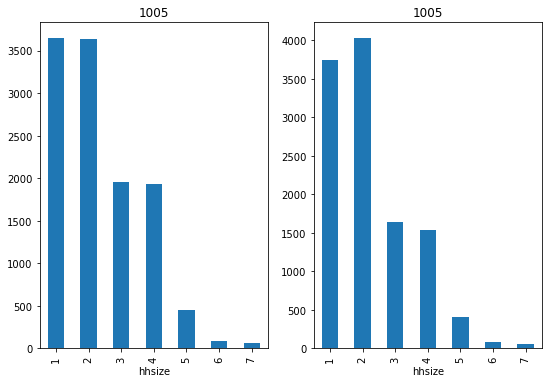

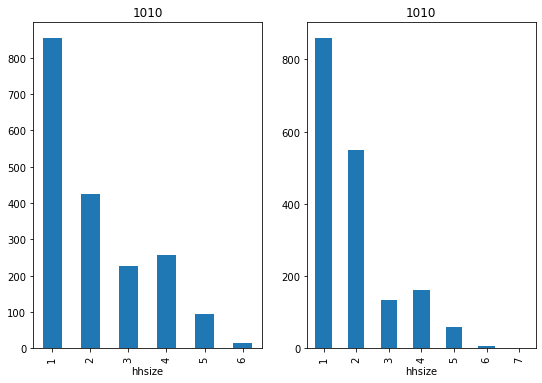

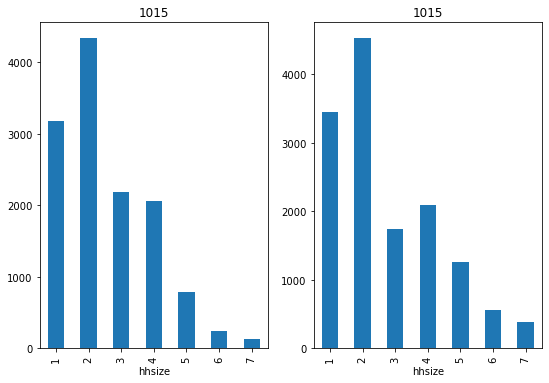

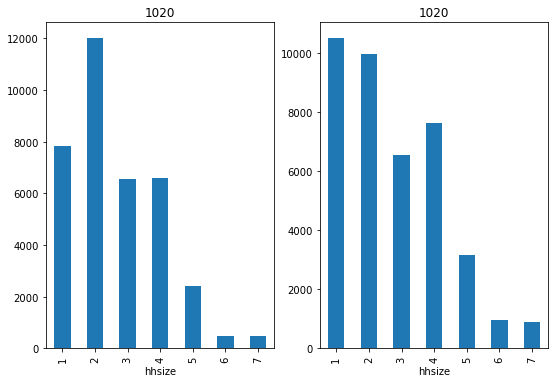

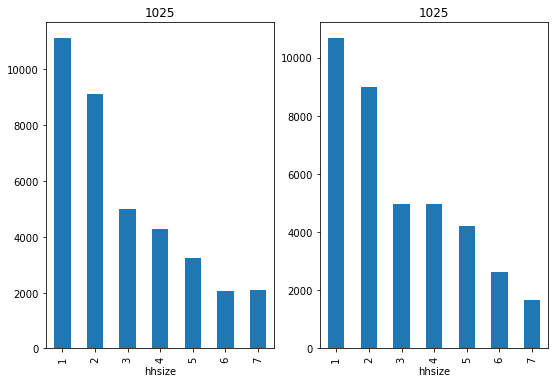

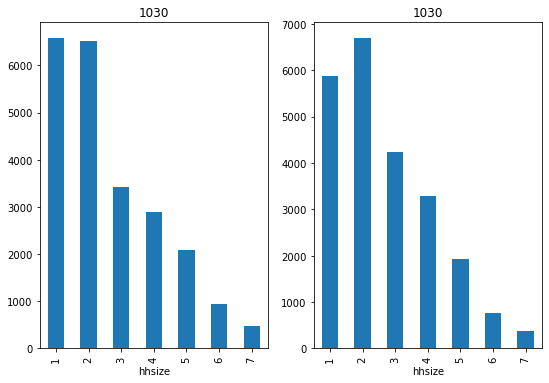

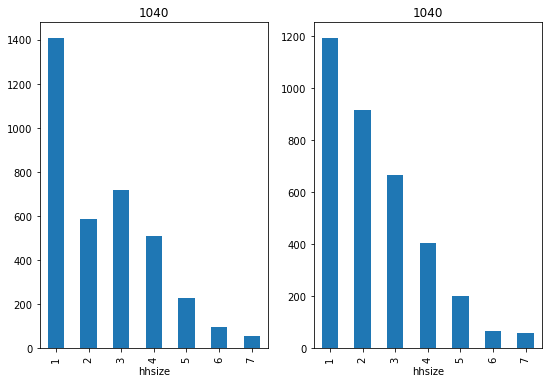

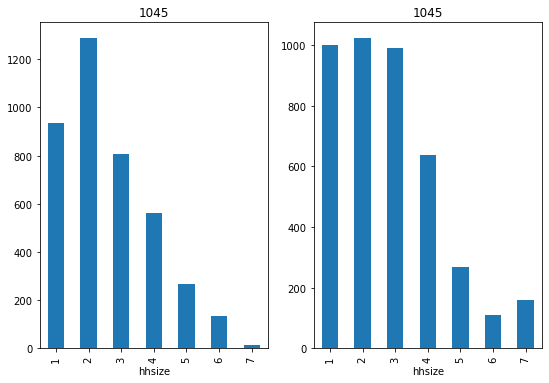

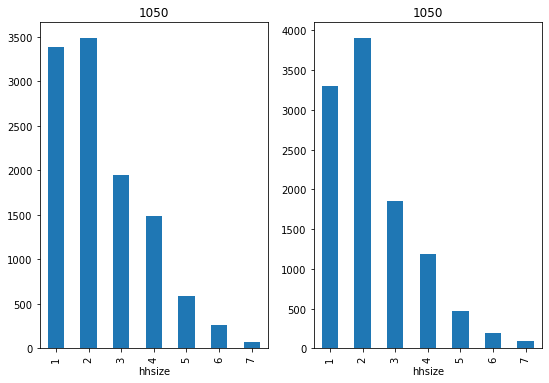

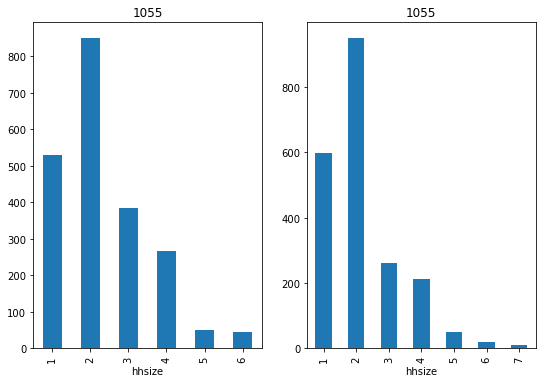

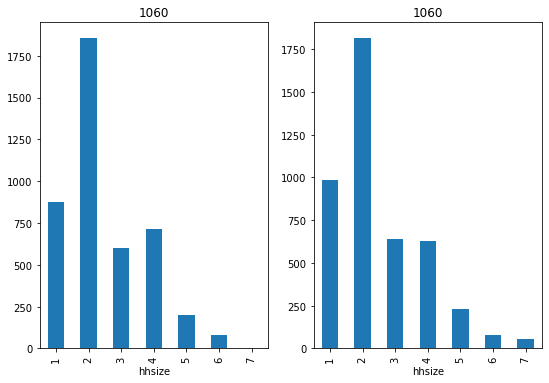

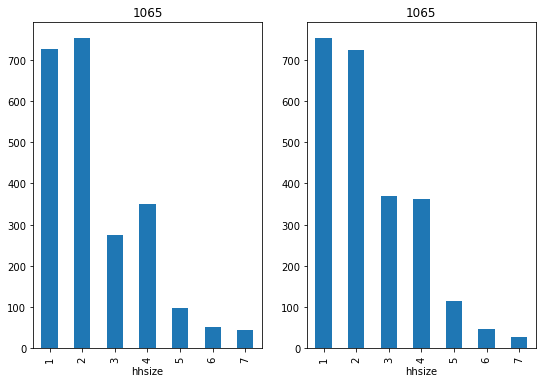

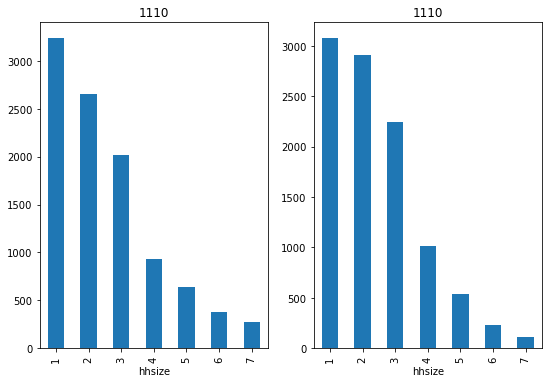

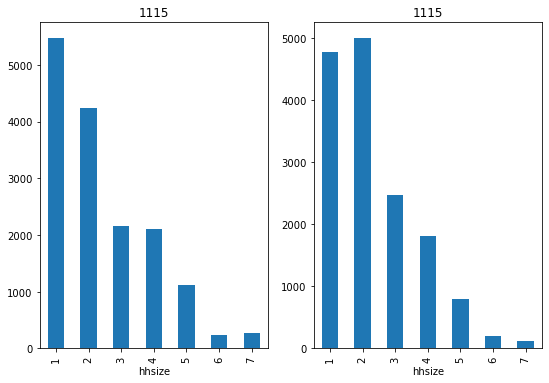

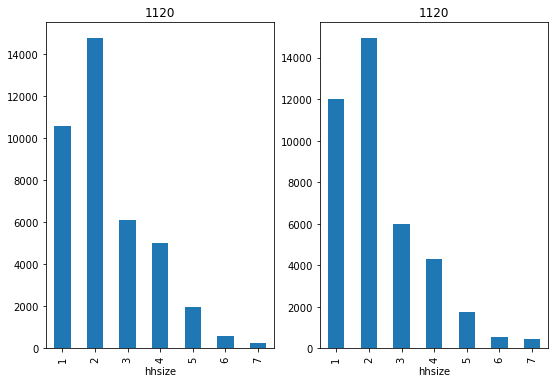

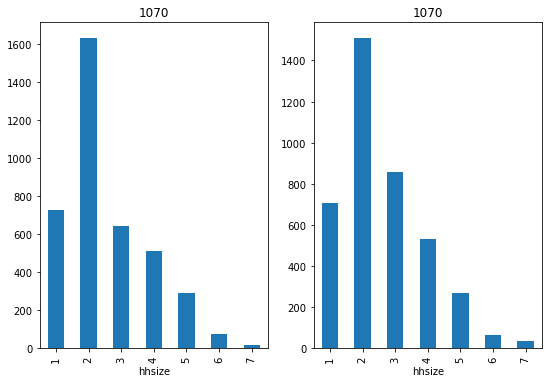

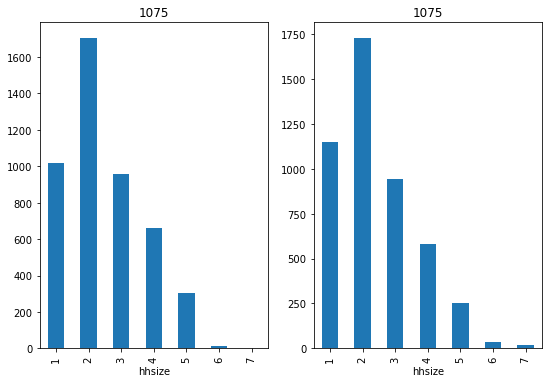

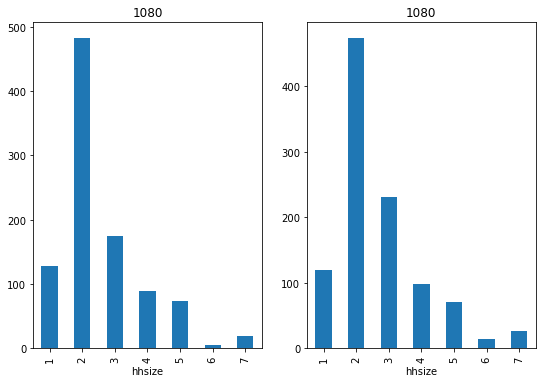

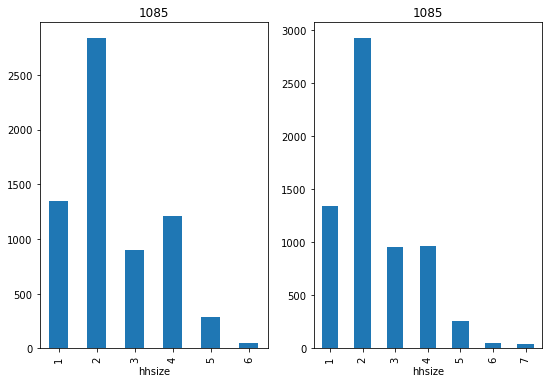

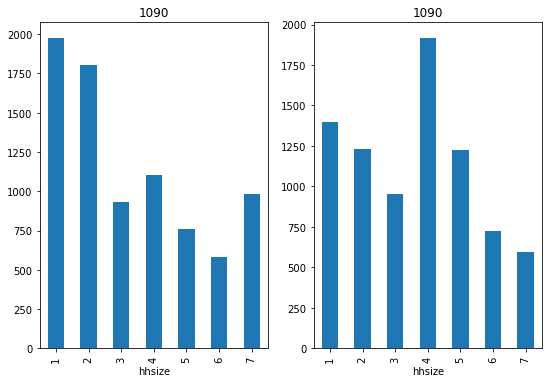

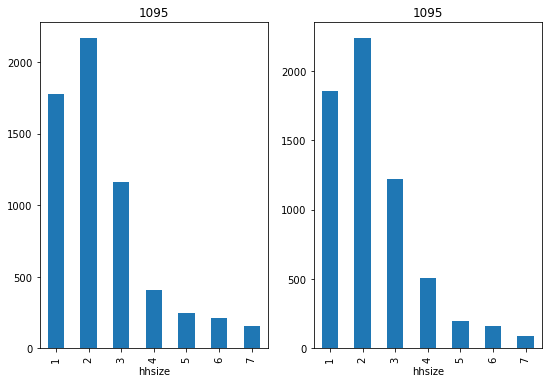

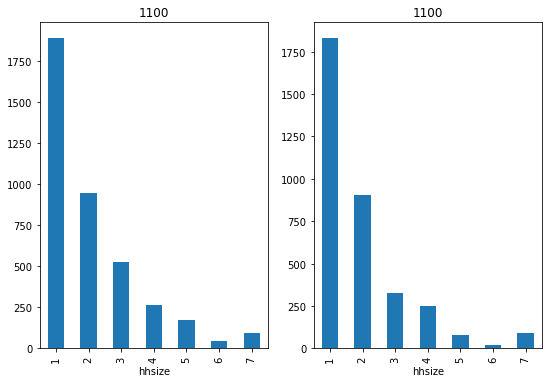

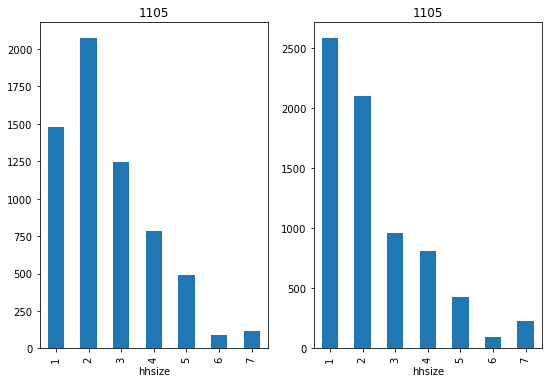

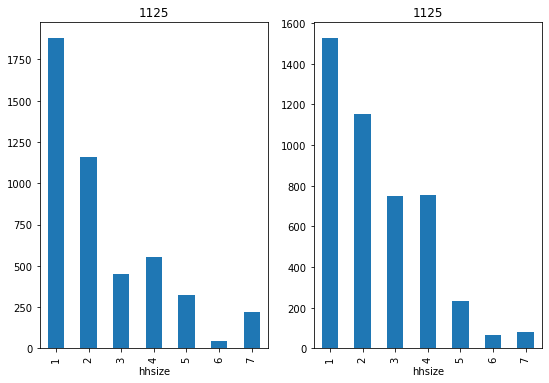

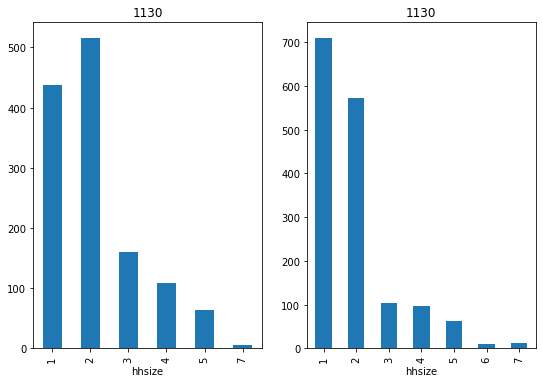

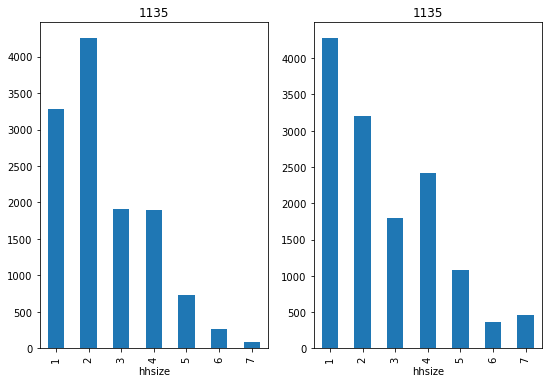

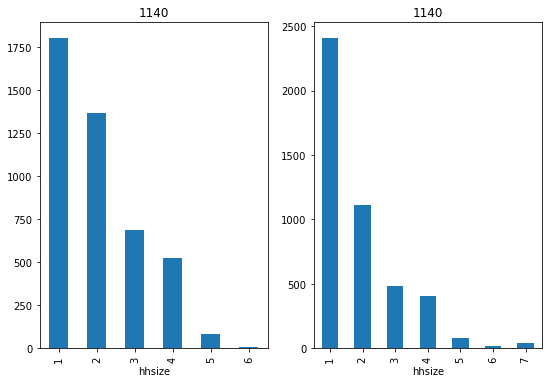

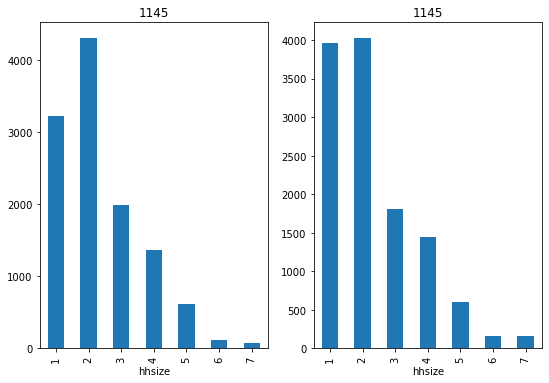

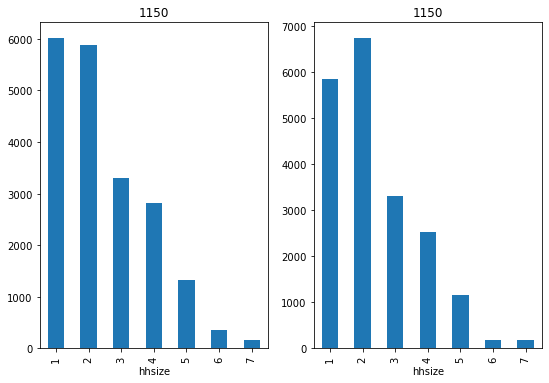

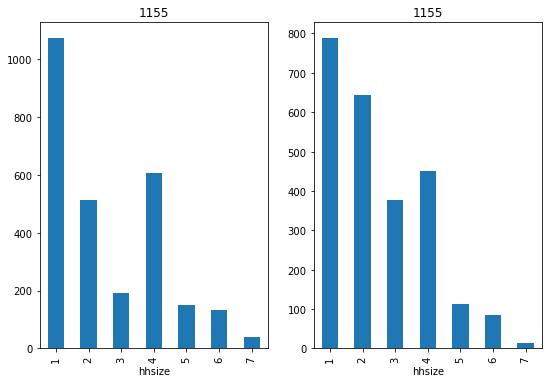

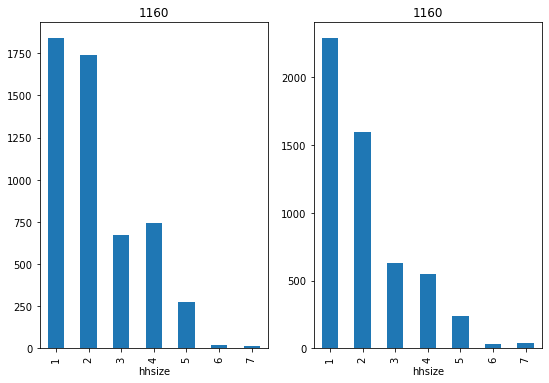

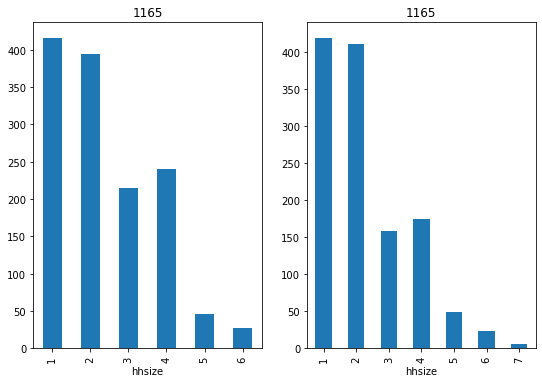

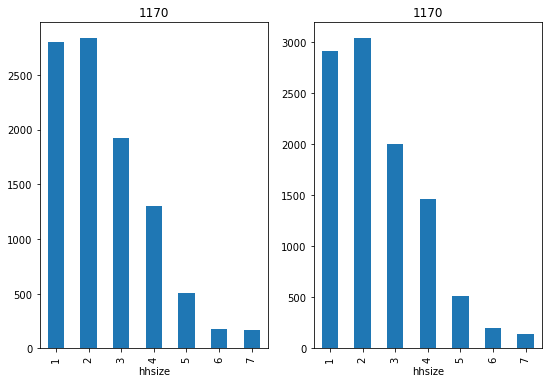

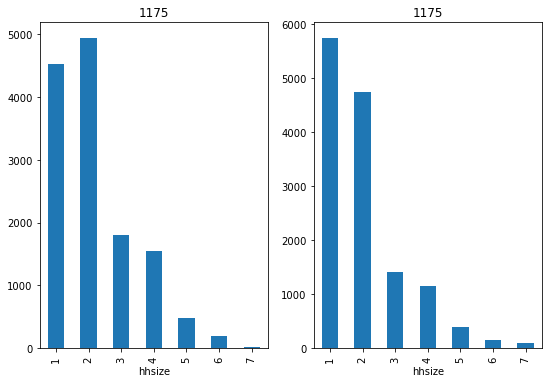

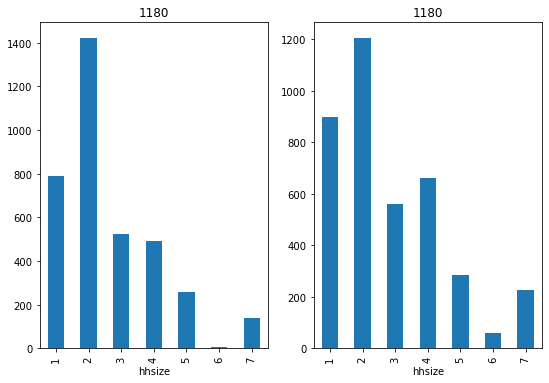

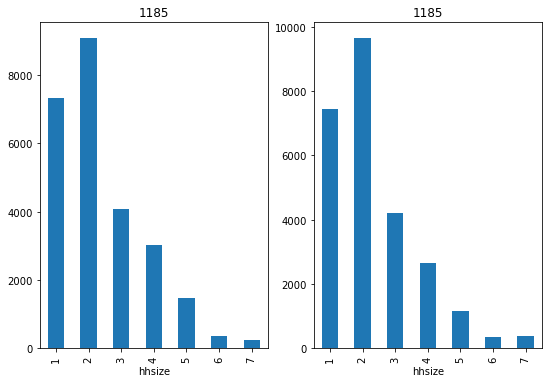

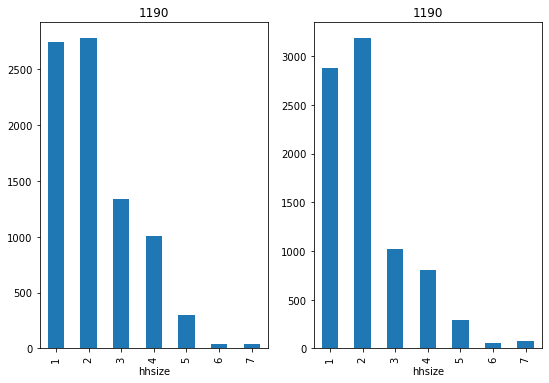

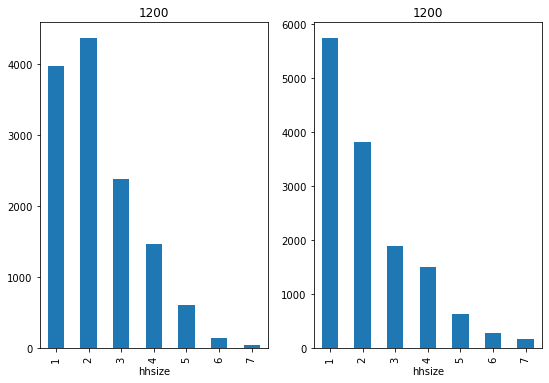

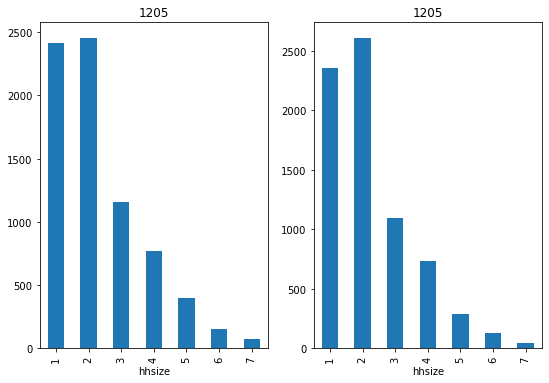

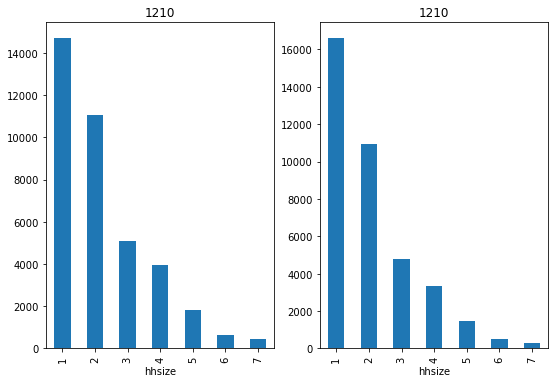

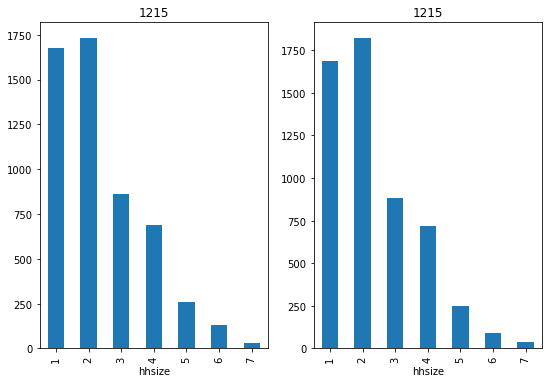

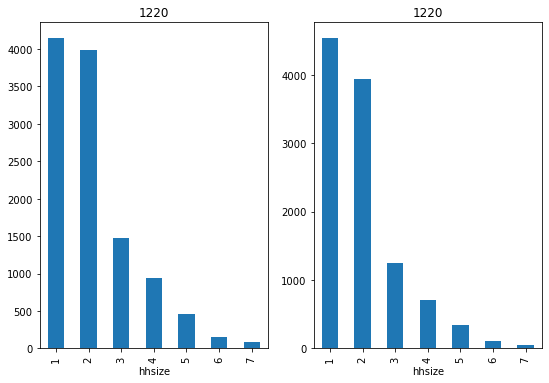

In [28]:
local_hdf = pd.HDFStore(os.path.join(run_folder, 'run1095.h5'), 'r')
h_base = prepare_data(local_hdf, 'base')
h_year = prepare_data(local_hdf, '2050')
lstdata=[h_base, h_year]
for city in hdf['/base/semmcds'].reset_index().query('large_area_id==3').semmcd_id.unique():
    geo_multiple_plots(lstdata, 'city_id', city, ['hhsize'])

#### Dropped buildings

In [17]:
year = 2032
db = hdf['/%s/dropped_buildings' % year]
b = hdf['/%s/buildings' % year]
p = hdf['/%s/parcels' % year]
db = db.join(p.semmcd, on='parcel_id')
b = b.join(p.semmcd, on='parcel_id')

In [18]:
b[b.semmcd==2050].residential_units.sum()

416.0

In [ ]:
2391432

#### Household controls

In [42]:
region_ct = hdf['/base/annual_household_control_totals']
region_hh = hdf["/2050/households"]
region_p = hdf["/2050/persons"]
region_target = pd.read_csv('/home/da/share/urbansim/RDF2050/model_inputs/base_tables/remi_pop_total.csv', index_col='large_area_id')

In [55]:
hdf["/2050/households"].query('large_area_id==3')

age_of_head  race_id        blkgrp  workers    valp  cars  \
household_id                                                              
1165208.0              40        1  261635601001        2  500000     2   
1165209.0              82        1  261635601001        0  150000     1   
1165210.0              52        1  261635601001        1       0     1   
1165211.0              63        1  261635601001        1  170000     1   
1165212.0              63        1  261635601001        1  170000     1   
...                   ...      ...           ...      ...     ...   ...   
3834873.0              68        4  261635513001        1   50000     2   
3834874.0              68        4  261635528012        2   50000     3   
3834875.0              68        4  261635522001        1   50000     2   
3834876.0              68        4  261635528012        1   50000     2   
3834877.0              68        4  261635528012        1   50000     2   

              income  children  large_area_id  ten  building_id  persons  \
household_id                                                               
1165208.0     203240         2              3    1      1273460        4   
1165209.0      55320         0              3    2      1272155        2   
1165210.0      97816         0              3    3      1273131        1   
1165211.0     108771         0              3    2      1272549        1   
1165212.0     108771         0              3    2      1273435        1   
...              ...       ...            ...  ...          ...      ...   
3834873.0      20821         3              3    2      1351271        6   
3834874.0      41101         3              3    2      1376300        6   
3834875.0      20821         3              3    2      1711679        6   
3834876.0      20821         3              3    2      1161510        6   
3834877.0      20821         3              3    2      1476552        6   

              household_type  
household_id                  
1165208.0                 17  
1165209.0                  7  
1165210.0                  8  
1165211.0                  8  
1165212.0                  8  
...                      ...  
3834873.0                  4  
3834874.0                 10  
3834875.0                  4  
3834876.0                  4  
3834877.0                  4  

[449561 rows x 13 columns]

In [52]:
region_ct.loc[2020].query('large_area_id==3').total_number_of_households.sum()

455576

In [53]:
region_ct.loc[2050].query('large_area_id==3').total_number_of_households.sum()

449617

In [6]:
max_cols = region_ct.columns[
	region_ct.columns.str.endswith("_max") & (region_ct == -1).any(axis=0)
]
region_ct[max_cols] = region_ct[max_cols].replace(-1, np.inf)
region_ct[max_cols] += 1

In [7]:
region_hh.index = region_hh.index.astype(int)
region_p.index = region_p.index.astype(int)

In [8]:
region_ct_2050 = region_ct.loc[2050]
region_simulated_hh_2050 = [filter_table(region_hh, region_ct_2050.iloc[i], 'total_number_of_households').shape[0] for i in range(region_ct_2050.shape[0])]

In [9]:
region_ct.loc[2050, 'region_simulated_hh_2050'] = pd.Series(region_simulated_hh_2050, index=region_ct_2050.index)

In [10]:
region_ct.loc[2050, 'abs_diff'] = (region_ct.loc[2050, 'region_simulated_hh_2050']  - region_ct.loc[2050, 'total_number_of_households'] ).abs()
region_ct.loc[2050, 'ratio'] = region_ct.loc[2050, 'region_simulated_hh_2050']  / region_ct.loc[2050, 'total_number_of_households'] 

In [12]:
region_ct.loc[2050].sort_values(by='abs_diff', ascending=False).head(20)

,age_of_head_min,children_max,income_max,race_id,age_of_head_max,cars_min,persons_max,cars_max,children_min,income_min,workers_max,persons_min,total_number_of_households,workers_min,large_area_id,region_simulated_hh_2050,abs_diff,ratio
year,,,,,,,,,,,,,,,,,,
2050,35,1.0,31704,2,65.0,0,2.0,1.0,0,0,1.0,1,12220,0,5,11559.0,661.0,0.945908
2050,35,1.0,31704,2,65.0,1,2.0,2.0,0,0,1.0,1,7196,0,5,6811.0,385.0,0.946498
2050,35,1.0,64016,2,65.0,1,2.0,2.0,0,31705,2.0,1,5457,1,5,5804.0,347.0,1.063588
2050,35,1.0,31704,2,65.0,1,2.0,2.0,0,0,2.0,1,4536,1,5,4825.0,289.0,1.063713
2050,65,1.0,113190,4,inf,2,4.0,3.0,0,64017,3.0,3,1650,2,5,1421.0,229.0,0.861212
2050,65,1.0,113190,3,inf,3,5.0,inf,0,64017,2.0,4,2767,1,161,2557.0,210.0,0.924106
2050,65,1.0,1534131,1,inf,2,3.0,3.0,0,113191,2.0,2,4790,1,125,4995.0,205.0,1.042797
2050,35,1.0,31704,2,65.0,0,3.0,1.0,0,0,1.0,2,3273,0,5,3072.0,201.0,0.938588
2050,65,1.0,113190,1,inf,2,3.0,3.0,0,64017,1.0,2,7312,0,125,7139.0,173.0,0.976340


In [13]:
# diff by ratio
region_ct.loc[2050]['abs_diff'].sum()/region_ct.loc[2050]["total_number_of_households"].sum()

0.017398918772793995

#### MCD totals

In [13]:
mcd_total = pd.read_csv('/home/da/share/urbansim/RDF2050/model_inputs/base_tables/mcd_totals_2020_2050_nov15.csv', index_col='mcd')
semmcds = hdf['/base/semmcds']
semmcds = semmcds.reset_index()[['semmcd_id', 'large_area_id']]
semmcds = semmcds.rename(columns={'semmcd_id': 'mcd'})


In [72]:
year = 2021
hh_cur = hdf["/%s/households"%year]
p = hdf["/%s/parcels"%year]
b_cur = hdf["/%s/buildings"%year]
b_cur = b_cur.join(p.semmcd, on='parcel_id')
hh_cur = hh_cur.join(b_cur.semmcd, on='building_id')
b_temp = b_cur[['semmcd', 'mcd_model_quota']]
qt_vs_growth = b_temp[b_temp.semmcd.isin(semmcds.query('large_area_id==3').mcd)].groupby('semmcd').sum()
hh_next = hdf["/%s/households"%(year+1)]
p = hdf["/%s/parcels"%(year+1)]
b_next = hdf["/%s/buildings"%(year+1)]
b_next = b_next.join(p.semmcd, on='parcel_id')
hh_next = hh_next.join(b_next.semmcd, on='building_id')
qt_vs_growth['cur'] = hh_cur.query('large_area_id==3').semmcd.value_counts()
qt_vs_growth['next'] = hh_next.query('large_area_id==3').semmcd.value_counts()
qt_vs_growth['diff'] = qt_vs_growth.next - qt_vs_growth.cur

In [73]:
b_temp.query('(semmcd==1025) and (mcd_model_quota>0)').sum()

semmcd             53300.0
mcd_model_quota      363.0
dtype: float64

In [74]:
hh_cur.building_id.isin(b_temp.query('(semmcd==1025) and (mcd_model_quota>0)').index).sum()

363

In [70]:
hh_cur[hh_cur.building_id.isin(b_temp.query('(semmcd==1025) and (mcd_model_quota>0)').index)]

,race_id,age_of_head,cars,blkgrp,large_area_id,children,ten,persons,income,building_id,valp,workers,household_type,semmcd
household_id,,,,,,,,,,,,,,
1225546.0,1,31,1,261635647001,3,1,3,3,76706,9014524,0,2,12,1025.0
1255384.0,1,27,0,261635547001,3,0,2,1,15375,9014524,110000,0,3,1025.0
1277462.0,1,56,1,261635569002,3,0,1,1,27166,9014524,95000,1,2,1025.0
1383111.0,2,37,0,261635669001,3,3,3,4,10443,9014550,0,1,5,1025.0
1498125.0,1,47,1,261635918003,3,0,1,1,25773,9014550,300000,0,2,1025.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3368980.0,3,78,1,261251673001,3,0,3,1,14129,9014550,0,0,1,1025.0
3369667.0,4,68,1,261635645021,3,0,1,1,17386,9014550,80000,0,1,1025.0
3369745.0,4,68,2,261635797003,3,0,1,1,8772,9014524,88000,0,1,1025.0


In [69]:
hh_next[hh_next.building_id.isin(b_temp.query('(semmcd==1025) and (mcd_model_quota>0)').index)]

,race_id,age_of_head,cars,blkgrp,large_area_id,children,ten,persons,income,building_id,valp,workers,household_type,semmcd
household_id,,,,,,,,,,,,,,
1225546.0,1,31,1,261635647001,3,1,3,3,76706,9014524,0,2,12,1025.0
1255384.0,1,27,0,261635547001,3,0,2,1,15375,9014524,110000,0,3,1025.0
1277462.0,1,56,1,261635569002,3,0,1,1,27166,9014524,95000,1,2,1025.0
1383111.0,2,37,0,261635669001,3,3,3,4,10443,9014550,0,1,5,1025.0
1498125.0,1,47,1,261635918003,3,0,1,1,25773,9014550,300000,0,2,1025.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370299.0,1,51,1,261635715003,3,3,3,12,32728,9014550,0,2,11,1025.0
3370384.0,1,36,3,261635807001,3,3,1,16,47251,9014550,200000,1,11,1025.0
3370399.0,1,36,3,261635786004,3,3,1,16,47251,9014550,200000,1,11,1025.0


In [81]:
b_cur[b_cur.index.isin(b_temp.query('(semmcd==1025) and (mcd_model_quota>0)').index)]

,year_built,event_id,sqft_per_unit,sp_filter,mcd_model_quota,non_residential_sqft,building_type_id,market_value,sqft_price_res,residential_units,parcel_id,improvement_value,sqft_price_nonres,land_area,stories,hu_filter,city_id,semmcd
building_id,,,,,,,,,,,,,,,,,,
1200434,2008,0,3266.0,0,1.0,0.000000,81,453553.128864,109.447306,1.0,1038635,421911.816957,0.0,1633,2.00,0,1025,1025
1169899,2004,0,3307.0,0,1.0,0.000000,81,840267.912334,333.988944,1.0,1014865,741317.833736,0.0,3307,1.00,0,1025,1025
8924350,2021,9041772,4300.0,0,1.0,0.000000,81,0.000000,262.484473,1.0,1014749,0.000000,0.0,0,1.00,0,1025,1025
8924351,2021,9041778,4300.0,0,1.0,0.000000,81,0.000000,225.797864,1.0,1014769,0.000000,0.0,0,1.00,0,1025,1025
8926365,2021,9048209,1600.0,0,1.0,0.000000,81,0.000000,123.620792,1.0,1038616,0.000000,0.0,0,1.75,0,1025,1025
8926611,2021,9048458,1600.0,0,1.0,0.000000,81,0.000000,321.049965,1.0,1022705,0.000000,0.0,0,1.75,0,1025,1025
8942667,2021,0,1107.6,0,1.0,75.932200,81,0.000000,126.216003,1.0,1038608,0.000000,0.0,0,1.00,0,1025,1025
8942684,2021,0,1183.6,0,1.0,169.028025,81,0.000000,183.679118,1.0,1017520,0.000000,0.0,0,1.00,0,1025,1025
8942694,2021,0,1040.6,0,1.0,86.062500,81,0.000000,139.933935,1.0,1027503,0.000000,0.0,0,1.00,0,1025,1025


In [44]:
qt_vs_growth

,mcd_model_quota,cur,next,diff
semmcd,,,,
1005,12.0,11395,11402,7
1010,2.0,1780,1778,-2
1015,118.0,13591,13631,40
1020,394.0,38926,39107,181
1025,186.0,36081,35865,-216
1030,0.0,21626,21613,-13
1040,21.0,3437,3451,14
1045,7.0,3994,3997,3
1050,0.0,10831,10825,-6


In [17]:
# number of hh dont have building_id
hh[hh.building_id == -1].large_area_id.value_counts()

125    17765
3       8507
99      6807
115     3668
93      3296
147     1442
Name: large_area_id, dtype: int64

In [13]:
simulated_mcd_hh = region_hh.semmcd.fillna(-1).value_counts()

In [27]:
region_hh

,cars,children,race_id,income,ten,persons,workers,valp,age_of_head,building_id,large_area_id,blkgrp,household_type,semmcd
household_id,,,,,,,,,,,,,,
1,2,0,1,147811,1,2,2,250000,50,4015129,161,261614200001,14,4015
3,1,0,1,74656,1,1,0,200000,61,4024154,161,261614200001,8,4015
8,4,0,1,64331,1,2,1,325000,37,9084828,161,261614200001,8,4005
9,2,0,1,103250,1,2,2,159000,57,4022744,161,261614200001,8,4015
10,2,4,4,128248,1,6,2,230000,37,4019564,161,261614200001,17,4015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3869994,1,1,4,46729,2,4,1,225000,81,2480148,125,261251681002,10,2072
3869995,1,1,4,46729,2,4,1,225000,81,2934148,125,261251681002,10,2010
3869996,4,0,4,31240,1,5,2,600000,75,2136405,125,261251561001,4,2072


In [21]:
simulated_mcd_hh

5       257650
4005     55031
3130     54344
3115     53847
3030     47712
         ...  
2172        59
3045        35
2252         8
2073         8
6142         1
Name: semmcd, Length: 237, dtype: int64

In [23]:
diff = simulated_mcd_hh - mcd_total['2050']
mcd_total_vs_simulated = (diff)[diff.abs().sort_values(ascending=False).index]
mcd_total_vs_simulated.index = mcd_total_vs_simulated.index.astype(int)

In [24]:
mcd_total_vs_simulated.fillna(0).astype(int).head(50)

2172   -11205
2252   -10648
2145     4673
4005     4624
3110     3597
3115    -3294
2190     3164
2290     3130
6135    -2910
2073    -2817
2030    -2689
4110    -2616
4080    -2519
2115     2488
1025    -2302
2175     2275
2215     2227
2160     2199
3060     2192
2235     1778
2260     1744
1020    -1651
3130    -1637
4135    -1562
2240    -1561
2060     1559
6040     1536
1110     1522
3030     1517
2075    -1495
2170     1464
1210     1426
2150    -1412
3120    -1399
3135    -1336
1105    -1320
3025    -1297
7065     1250
4100     1240
6142    -1227
2285     1188
2015    -1179
7010     1166
2180    -1155
2095     1102
2220    -1086
7035    -1059
2005     1048
2205      916
7045      901
dtype: int64

In [26]:
simulated_mcd_hh.loc[4005]

55031

In [140]:
hdf["/base/semmcds"].loc[2252]

city_name        Southfield Twp
county_id                   125
large_area_id               125
Name: 2252, dtype: object

In [ ]:
b50 = b50.join(p50.semmcd, on='parcel_id')

In [147]:
b50[b50.semmcd == 2252].shape

(9, 16)

#### HH viz by year for MCD

In [3]:
run_folder = "/home/da/semcog_urbansim/runs"
run_num = "run307"
hdf = pd.HDFStore(os.path.join(run_folder, '%s.h5'%run_num), 'r')
mcd_total = pd.read_csv('/home/da/share/urbansim/RDF2050/model_inputs/base_tables/mcd_totals_2020_2050_nov15.csv', index_col='mcd')

hh_by_mcd_year = pd.DataFrame(index=mcd_total.index)
for year in range(2020, 2041):
	if "/%s/parcels" % year not in hdf.keys():
		break
	p = hdf["/%s/parcels" % year]
	b = hdf["/%s/buildings" % year]
	hh = hdf["/%s/households" % year]
	b = b.join(p.semmcd, on='parcel_id')
	hh = hh.join(b.semmcd, on='building_id')
	hh_vcount = hh.semmcd.fillna(-1).astype(int).value_counts()
	hh_by_mcd_year.loc[:, str(year)] = hh_vcount

In [4]:
hh_by_mcd_year

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,...,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040
mcd,,,,,,,,,,,,,,,,,,,,,
5,266342.0,264199.0,261667.0,262464.0,263738.0,263948.0,264180.0,264037.0,263810.0,263492.0,...,262696.0,262125.0,261715.0,261218.0,260817.0,260564.0,260224.0,259797.0,259099.0,258836.0
1005,11639.0,11274.0,11153.0,11122.0,11149.0,11152.0,11135.0,11128.0,11135.0,11130.0,...,11117.0,11130.0,11160.0,11132.0,11146.0,11169.0,11197.0,11192.0,11194.0,11198.0
1010,1847.0,1846.0,1827.0,1824.0,1806.0,1806.0,1795.0,1791.0,1794.0,1789.0,...,1770.0,1775.0,1778.0,1779.0,1775.0,1776.0,1773.0,1775.0,1774.0,1778.0
1015,12826.0,12966.0,13019.0,13072.0,13060.0,13091.0,13109.0,13096.0,13125.0,13114.0,...,13149.0,13163.0,13191.0,13182.0,13200.0,13166.0,13170.0,13177.0,13154.0,13159.0
1020,36130.0,36897.0,37094.0,37211.0,37328.0,37494.0,37673.0,37803.0,37932.0,38083.0,...,38275.0,38353.0,38398.0,38424.0,38496.0,38534.0,38557.0,38580.0,38556.0,38557.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7080,5265.0,5298.0,5332.0,5409.0,5439.0,5482.0,5515.0,5541.0,5562.0,5598.0,...,5713.0,5790.0,5855.0,5964.0,6106.0,6250.0,6393.0,6521.0,6633.0,6745.0
7085,891.0,874.0,872.0,871.0,886.0,893.0,895.0,905.0,907.0,911.0,...,918.0,917.0,917.0,914.0,926.0,935.0,941.0,949.0,957.0,957.0
7090,2232.0,2343.0,2375.0,2385.0,2411.0,2434.0,2456.0,2471.0,2480.0,2489.0,...,2512.0,2532.0,2537.0,2536.0,2537.0,2539.0,2543.0,2542.0,2543.0,2542.0


In [26]:
hh_by_mcd_year['la'] = semmcds.set_index('mcd')

In [32]:
hh_by_mcd_year.to_csv('~/semcog_urbansim/data/cache/hh_by_mcd_year.csv')

In [ ]:
pd.DataFrame({"mcd_total":mcd_total.loc[5],"simulated":hh_by_mcd_year.loc[5]})

In [38]:
j = hdf["/2020/jobs"]
b = hdf["/2020/buildings"]
j[~j.building_id.isin(b.index)]

,home_based_status,semcog_id,sqft,sector_id,building_id,large_area_id
1812963,0,247163,1000,7,-1,3
188995,0,813978,700,12,-1,3
192376,0,814024,1000,12,-1,3
208504,0,814109,700,12,-1,3
221324,0,814010,700,12,-1,3
...,...,...,...,...,...,...
2144495,0,579518,400,15,-1,161
2144812,0,579518,400,15,-1,161
2147177,0,579518,400,15,-1,161
910938,0,128181,250,18,-1,161


In [45]:
j = hdf["/2020/jobs"]
hh = hdf["/2020/households"]
b = hdf["/2020/buildings"]
# hh.building_id.isin(b.index)
# j[~j.building_id.isin(b.index)]

In [46]:
(~hh.building_id.isin(b.index)).sum()


0

In [50]:
hdf["/base/households"].shape

(1936872, 13)

### Jobs

#### Jobs control

In [3]:
jct = hdf['/base/annual_employment_control_totals']

In [4]:
jct

large_area_id  total_number_of_jobs
year sector_id home_based_status                                     
2020 1         0                              3                  1227
               1                              3                   460
     2         0                              3                 13806
               1                              3                 11959
     3         0                              3                 58960
...                                         ...                   ...
2050 16        1                            161                  2416
     17        0                            161                  8666
               1                            161                  3302
     18        0                            161                  6494
               1                            161                    74

[8928 rows x 2 columns]

#### Jobs events

In [32]:
refinement = hdf['/base/refiner_events']
jobs_prev = hdf['/base/jobs']
jobs_after = hdf['/2050/jobs']
buildings_prev = hdf['/base/buildings']
buildings_after = hdf['/2050/buildings']

In [33]:
add_event = refinement.query('action=="add"')
for _, row in add_event.iterrows():
    bids = buildings_after.query(row.location_expression).index.to_list()
    prev = jobs_prev[jobs_prev.building_id.isin(bids)].shape[0]
    after = jobs_after[jobs_after.building_id.isin(bids)].shape[0]
    target = row.amount
    print("Transcation: %s\t 2020: %s\t 2050: %s\t event_added: %s" % (row.transaction_id, prev, after, target))

Transcation: 1	 2020: 0	 2050: 249	 event_added: 250
Transcation: 2	 2020: 0	 2050: 996	 event_added: 1000
Transcation: 3	 2020: 0	 2050: 1185	 event_added: 1200
Transcation: 4	 2020: 0	 2050: 877	 event_added: 300
Transcation: 5	 2020: 0	 2050: 1340	 event_added: 1700
Transcation: 5	 2020: 0	 2050: 900	 event_added: 1125
Transcation: 5	 2020: 0	 2050: 809	 event_added: 1025
Transcation: 6	 2020: 596	 2050: 990	 event_added: 400
Transcation: 7	 2020: 0	 2050: 146	 event_added: 60
Transcation: 8	 2020: 0	 2050: 146	 event_added: 100
Transcation: 9	 2020: 0	 2050: 549	 event_added: 240
Transcation: 10	 2020: 0	 2050: 549	 event_added: 390
Transcation: 11	 2020: 369	 2050: 2061	 event_added: 2000
Transcation: 14	 2020: 0	 2050: 2273	 event_added: 2500
Transcation: 15	 2020: 0	 2050: 198	 event_added: 200
Transcation: 16	 2020: 0	 2050: 1200	 event_added: 1200
Transcation: 17	 2020: 1055	 2050: 2951	 event_added: 2350
Transcation: 18	 2020: 0	 2050: 120	 event_added: 200
Transcation: 19	 2

In [35]:
target_event = refinement.query('action=="target"')
for _, row in target_event.iterrows():
    bids = buildings_after.query(row.location_expression).index.to_list()
    prev = jobs_prev[jobs_prev.building_id.isin(bids)].shape[0]
    after = jobs_after[jobs_after.building_id.isin(bids)].shape[0]
    target = row.amount
    print("Transcation: %s\t 2020: %s\t 2050: %s\t event_target: %s" % (row.transaction_id, prev, after, target))

Transcation: 20	 2020: 544	 2050: 8	 event_target: 0
Transcation: 41	 2020: 162	 2050: 1	 event_target: 0
Transcation: 74	 2020: 131	 2050: 5	 event_target: 0
Transcation: 94	 2020: 5	 2050: 1	 event_target: 0


In [34]:
subtract_event = refinement.query('action=="subtract"')
for _, row in subtract_event.iterrows():
    bids = buildings_after.query(row.location_expression).index.to_list()
    prev = jobs_prev[jobs_prev.building_id.isin(bids)].shape[0]
    after = jobs_after[jobs_after.building_id.isin(bids)].shape[0]
    subtract = row.amount
    print("Transcation: %s\t 2020: %s\t 2050: %s\t event_subtract: %s" % (row.transaction_id, prev, after, subtract))

Transcation: 7	 2020: 2924	 2050: 3384	 event_subtract: 60
Transcation: 8	 2020: 750	 2050: 608	 event_subtract: 100
Transcation: 12	 2020: 12	 2050: 3	 event_subtract: 263
Transcation: 13	 2020: 0	 2050: 0	 event_subtract: 200
Transcation: 21	 2020: 909	 2050: 80	 event_subtract: 950
Transcation: 14	 2020: 87	 2050: 3	 event_subtract: 100
Transcation: 14	 2020: 937	 2050: 818	 event_subtract: 100
Transcation: 14	 2020: 482	 2050: 181	 event_subtract: 300
Transcation: 14	 2020: 908	 2050: 797	 event_subtract: 100
Transcation: 14	 2020: 122	 2050: 4	 event_subtract: 150
Transcation: 14	 2020: 138	 2050: 57	 event_subtract: 100
Transcation: 14	 2020: 112	 2050: 8	 event_subtract: 100
Transcation: 14	 2020: 348	 2050: 46	 event_subtract: 300
Transcation: 14	 2020: 46	 2050: 5	 event_subtract: 50
Transcation: 30	 2020: 401	 2050: 28	 event_subtract: 375
Transcation: 31	 2020: 184	 2050: 36	 event_subtract: 150
Transcation: 31	 2020: 340	 2050: 340	 event_subtract: 300
Transcation: 31	 2020

In [20]:
prev = jobs_prev[jobs_prev.building_id.isin(bids)].groupby('building_id').count().home_based_status
after = jobs_after[jobs_after.building_id.isin(bids)].groupby('building_id').count().home_based_status

In [41]:
hdf['/2021/jobs'].query('building_id==2593307').shape

,sector_id,home_based_status,large_area_id,total_number_of_jobs,region_simulated_j
1,1,1,3,460,468
3,2,1,3,11959,12048
5,3,1,3,2029,2059
7,4,1,3,3043,3135
9,5,1,3,6802,7053
10,6,0,3,44410,55688
15,8,1,3,1075,1119
16,9,0,3,28695,36305
19,10,1,3,9693,10048
20,11,0,3,11232,15942


In [40]:
hdf['/2022/jobs'].query('building_id==2593307').shape

(40, 6)

##### end 

In [51]:
inhdf = pd.HDFStore('~/share/urbansim/RDF2050/model_inputs/base_hdf/forecast_data_input_112222.h5', 'r')

In [89]:
j = hdf['base/jobs']
ec = hdf['base/annual_employment_control_totals']
# (j[j.building_id==-1].index.isin(hdf['base/jobs'].index)).sum()
ec = ec.loc[2020].reset_index()
region_simulated_j = [filter_table(j, ec.iloc[i], 'total_number_of_jobs').shape[0] for i in range(ec.shape[0])]
ec.loc[:, 'region_simulated_j'] = region_simulated_j

In [93]:
ec[ec.region_simulated_j>ec.total_number_of_jobs].head(20)

,sector_id,home_based_status,large_area_id,total_number_of_jobs,region_simulated_j
1,1,1,3,460,468
3,2,1,3,11959,12048
5,3,1,3,2029,2059
7,4,1,3,3043,3135
9,5,1,3,6802,7053
10,6,0,3,44410,55688
15,8,1,3,1075,1119
16,9,0,3,28695,36305
19,10,1,3,9693,10048
20,11,0,3,11232,15942


In [83]:
ec = hdf['base/annual_employment_control_totals']
# (j[j.building_id==-1].index.isin(hdf['base/jobs'].index)).sum()
ec = ec.loc[2020].reset_index()
# filter_table(j, ec.iloc[22], 'total_number_of_jobs')
ec.iloc[22]

,home_based_status,semcog_id,sqft,sector_id,building_id,large_area_id
47536,0,814085,900,12,1904133,3
47787,0,814085,900,12,1904131,3
47788,0,814334,900,12,1904131,3
47967,0,48431,900,12,1414803,3
48166,0,814085,900,12,1414803,3
...,...,...,...,...,...,...
2730070,0,273581,700,12,1347982,3
2730071,0,814098,400,12,1918309,3
2730072,0,289933,250,12,1170444,3
2730073,0,282292,250,12,1724093,3


In [79]:
region_simulated_j

[1227,
 460,
 13806,
 11959,
 58960,
 2029,
 17748,
 3043,
 55785,
 6802,
 44410,
 19369,
 390,
 13,
 3330,
 1075,
 28695,
 20271,
 39814,
 9693,
 11232,
 5180,
 23471,
 15578,
 23644,
 659,
 36274,
 8456,
 21617,
 82,
 39404,
 2217,
 29472,
 7812,
 10210,
 209,
 254,
 156,
 4061,
 2589,
 20174,
 957,
 6463,
 1076,
 10352,
 2827,
 9796,
 2860,
 3245,
 14,
 3768,
 1281,
 19925,
 5484,
 17597,
 5525,
 9843,
 130,
 9414,
 9304,
 28869,
 682,
 27348,
 10054,
 31935,
 182,
 23699,
 1995,
 16795,
 5083,
 29706,
 256,
 156,
 989,
 2784,
 3660,
 9161,
 669,
 2351,
 696,
 9367,
 1181,
 1363,
 1130,
 47,
 5,
 628,
 314,
 5363,
 4655,
 5427,
 2210,
 176,
 388,
 1676,
 1736,
 4309,
 131,
 7092,
 1068,
 927,
 1,
 7657,
 488,
 3967,
 1540,
 3028,
 72,
 403,
 961,
 13469,
 12464,
 60693,
 2130,
 9831,
 1467,
 40716,
 5782,
 10628,
 10973,
 335,
 34,
 2987,
 879,
 18697,
 14058,
 30076,
 7226,
 3020,
 2962,
 12810,
 11385,
 20232,
 354,
 31296,
 4875,
 10424,
 45,
 27670,
 2064,
 18690,
 5976,
 20170,

In [82]:
ec.iloc[22]

/tmp/ipykernel_170866/274758903.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  ec.loc[2020,12,0]


sector_id                  12
home_based_status           0
large_area_id               3
total_number_of_jobs    23471
region_simulated_j      23471
Name: 22, dtype: int64

In [84]:
j[(j.home_based_status==0)&(j.sector_id==12)&(j.large_area_id==3)&(j.building_id!=-1)]

,home_based_status,semcog_id,sqft,sector_id,building_id,large_area_id
47536,0,814085,900,12,1904133,3
47787,0,814085,900,12,1904131,3
47788,0,814334,900,12,1904131,3
47967,0,48431,900,12,1414803,3
48166,0,814085,900,12,1414803,3
...,...,...,...,...,...,...
2730070,0,273581,700,12,1347982,3
2730071,0,814098,400,12,1918309,3
2730072,0,289933,250,12,1170444,3
2730073,0,282292,250,12,1724093,3


In [20]:
j[j.building_id!=-1].shape

(2695168, 6)

In [33]:
ec.loc[2020,12,0]

/tmp/ipykernel_170866/274758903.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  ec.loc[2020,12,0]


large_area_id  total_number_of_jobs
year sector_id home_based_status                                     
2020 12        0                              3                 23471
               0                              5                  9414
               0                             93                  1676
               0                             99                 12810
               0                            115                   974
               0                            125                 49658
               0                            147                  1344
               0                            161                  6455

In [35]:
bj = hdf['base/jobs']
bj[(bj.large_area_id==3)&(bj.sector_id==12)&(bj.home_based_status==0)]

,home_based_status,semcog_id,sqft,sector_id,building_id,large_area_id
job_id,,,,,,
47536,0,814085,900,12,1904133,3
47787,0,814085,900,12,1904131,3
47788,0,814334,900,12,1904131,3
47967,0,48431,900,12,1414803,3
48166,0,814085,900,12,1414803,3
...,...,...,...,...,...,...
2730070,0,273581,700,12,1347982,3
2730071,0,814098,400,12,1918309,3
2730072,0,289933,250,12,1170444,3
